## xgboost results

This notebook contains the results from xgboost.

- XGBoost was first optmized with a very small grid (trees and learning rate)
- afterwards the selected features were used within a larger grid search space

We want to have the following results:
1. Results of the cross-validation
2. Results of the train / test split
3. SHAP results
4. interactions
5. target / decoys

Methods:
TBD

In [48]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import shap
shap.initjs()
data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_CO_NAVG_small.p", "rb"))
data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_CO_AVG_huge.p", "rb"))
data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_CO_NAVG_huge.p", "rb"))
#data_dic = pickle.load(open(r"..\results\xifaims_8PM4PM_OH_AVG_tiny.p", "rb"))

data_dic.keys()
#dict_keys(['best_features_gs', 'summary_gs', 'best_params_gs', 'xifaims_params', 'xifaims_config', 'xgb', 'predictions_df', 'data', 'metrics', 'df_unique', 'df_nonunique'])

dict_keys(['best_features_gs', 'summary_gs', 'best_params_gs', 'xifaims_params', 'xifaims_config', 'xgb', 'predictions_df', 'data', 'metrics', 'df_unique', 'df_nonunique'])

## Train-Test Split

The following table summarizes the metrics for training on 80% of the data and then predicting on the other 20%.


In [49]:
metrics_df = data_dic["metrics"]
metrics_df = metrics_df.round(2)
metrics_df = metrics_df.set_index("split")
metrics_df

,r2,pearsonr,MAE,MSE
split,,,,
Train,0.90,0.96,2.77,12.98
Validation,0.54,0.74,5.57,52.92
DX,0.49,0.74,5.57,42.61


## Best features:

Using mlxtend and the nested SequentialFeatureSelector + GridSearch the following features get choosen through a parsimony criterium:

In [50]:
features = data_dic["best_features_gs"]
print(features)

print(data_dic["best_params_gs"])

Index(['length1+length2', 'p.charge', 'aromatics', 'helix', 'turn', 'pi',
       'charge_glob', 'intrinsic_size_max', 'mv_size_std', 'mv_size_max',
       'polarity_size_max', 'secondstruc_sum', 'secondstruc_size_max',
       'static_size_max', 'm/z'],
      dtype='object')
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 0.1, 'n_estimators': 50, 'nthread': 1, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'seed': 42, 'subsample': 0.8}


# Cross-validation results

The CV was done using 3splits and negative_mean_squared_error as metric.

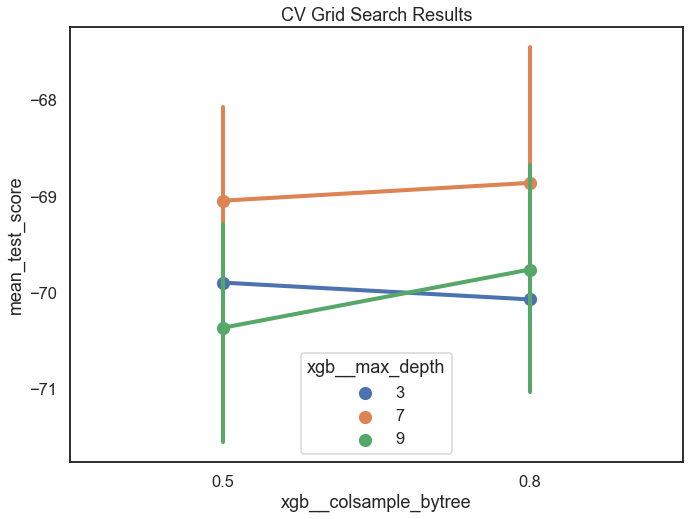

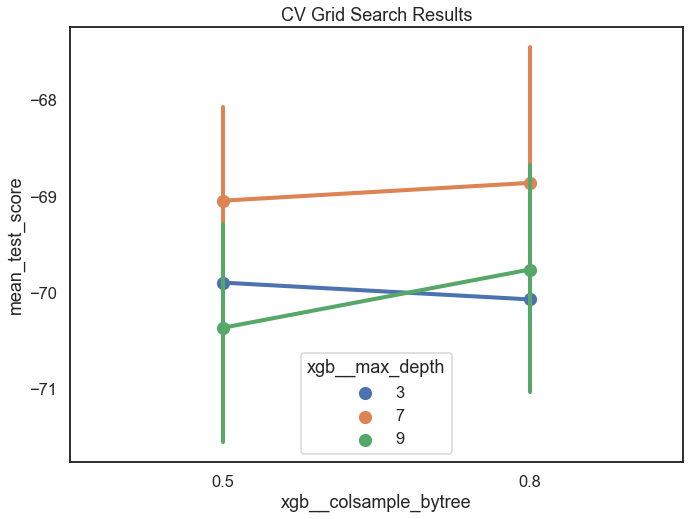

In [78]:
df_cv = data_dic["summary_gs"]
df_cv = df_cv.sort_values("rank_test_score", ascending=True)
df_cv.filter(regex="param|rank", axis=1).head(20)

def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    #cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig


plot_cv_results(df_cv, "xgb__colsample_bytree", "xgb__max_depth")

In [69]:
best_cv = df_cv
best_cv
#print(best_cv)
best_df = df_cv.filter(regex="split|rank")
best_df


,split0_test_score,split1_test_score,split2_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score
967,-61.105206,-65.038881,-58.725437,1,-9.592116,-8.574786,-7.722059
983,-61.105206,-65.038881,-58.725437,1,-9.592116,-8.574786,-7.722059
691,-60.933321,-64.130968,-60.253321,3,-9.669596,-8.539961,-7.284101
675,-60.933321,-64.130968,-60.253321,3,-9.669596,-8.539961,-7.284101
635,-60.392124,-65.554594,-59.797720,5,-10.790027,-9.905465,-8.507136
...,...,...,...,...,...,...,...
540,-82.882181,-89.875337,-81.349757,1147,-1.329346,-1.300249,-0.708330
266,-83.287188,-89.929211,-81.141771,1149,-1.535406,-1.619452,-0.701459
250,-83.287188,-89.929211,-81.141771,1149,-1.535406,-1.619452,-0.701459
542,-83.525932,-89.543637,-81.860955,1151,-1.595803,-1.405689,-0.693046


In [52]:
res_melt = best_df.melt(id_vars=["rank_test_score"])
res_melt = res_melt[res_melt["rank_test_score"] == 1]
res_melt["Split"] = ["Train" if "train" in i else "Test" for i in res_melt["variable"]]
res_melt



,rank_test_score,variable,value,Split
0,1,split0_test_score,-61.105206,Test
1,1,split0_test_score,-61.105206,Test
1152,1,split1_test_score,-65.038881,Test
1153,1,split1_test_score,-65.038881,Test
2304,1,split2_test_score,-58.725437,Test
2305,1,split2_test_score,-58.725437,Test
3456,1,split0_train_score,-9.592116,Train
3457,1,split0_train_score,-9.592116,Train
4608,1,split1_train_score,-8.574786,Train
4609,1,split1_train_score,-8.574786,Train


## Train - Validation Evaluation

Evaluate the results when the model was trained on 80%.

In [53]:
predictions_df = data_dic["predictions_df"]
predictions_df.Split.unique()
predictions_df["Split"] = predictions_df["Split"].str.replace("Test", "Validation")
predictions_df
predictions_df["diff"] = predictions_df["predictions"] -  predictions_df["observed"]
predictions_df["diff_abs"] = np.abs(predictions_df["predictions"] -  predictions_df["observed"])
predictions_df["Split"] = [f"{i} ({metrics_df.loc[i]['pearsonr']})" for i in predictions_df["Split"]]
predictions_df.head()



,predictions,observed,Split,diff,diff_abs
0,-44.523289,-44.952297,Train (0.96),0.429008,0.429008
1,-41.295475,-39.915943,Train (0.96),-1.379532,1.379532
2,-49.532871,-48.339296,Train (0.96),-1.193576,1.193576
3,-46.744507,-50.430219,Train (0.96),3.685713,3.685713
4,-57.059475,-60.936907,Train (0.96),3.877432,3.877432


<AxesSubplot:xlabel='Split', ylabel='diff'>

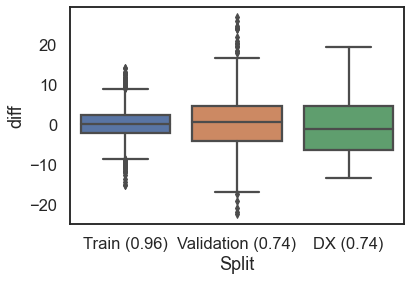

In [54]:
sns.boxplot(x="Split", y="diff", data=predictions_df)

<AxesSubplot:xlabel='Split', ylabel='diff_abs'>

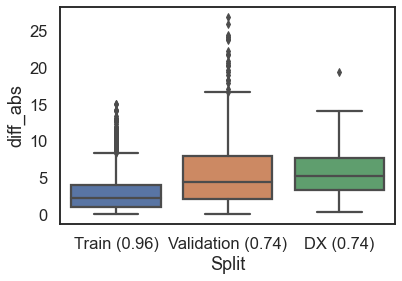

In [55]:
sns.boxplot(x="Split", y="diff_abs", data=predictions_df)

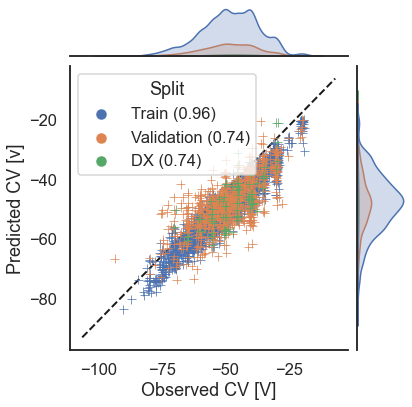

In [56]:
#fax = sns.jointplot(y="predictions", x="observed", hue="Split", data=predictions_df[predictions_df["Split"] != "DX"], marker="+", s=50)
fax = sns.jointplot(y="predictions", x="observed", hue="Split", data=predictions_df, marker="+", s=80)
fax.ax_joint.set(xlabel="Observed CV [V]", ylabel="Predicted CV [v]")
x0, x1 = fax.ax_joint.get_xlim()
y0, y1 = fax.ax_joint.get_ylim()
fax.ax_joint.plot([x0, x1], [y0, y1], ls="--", zorder=-1, lw=2, c="k")



### SHAP Analysis
Use shap to determine:
1. most important parameters
2. interesting interactions

In [57]:
print("Loading model, train, val, dx features and best features")
# model
model = data_dic["xgb"]
print(data_dic["data"].keys())

# data consists of tuples with meta data and feature data
all_data = data_dic["data"]
TT_train, TT_train_features = all_data["TT_train"] 
TT_val, TT_val_features = all_data["TT_val"] 
DX = all_data["DX"] 
#print(all_data)

# use shortcut
X = TT_val_features[features]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_values_inter = shap.TreeExplainer(model).shap_interaction_values(X)

Loading model, train, val, dx features and best features
dict_keys(['TT_train', 'TT_val', 'DX'])


<AxesSubplot:xlabel='SHAP value (impact on model output)'>

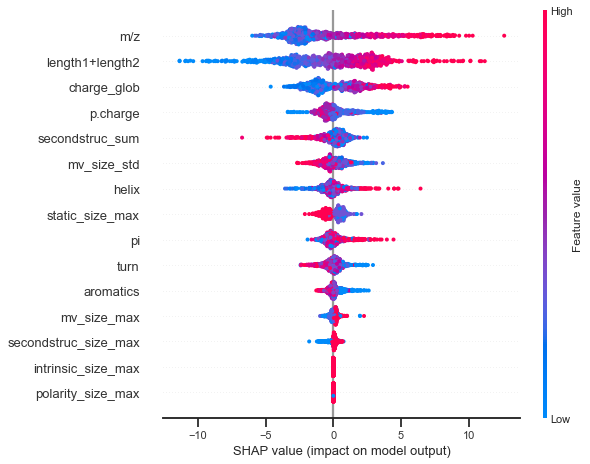

In [58]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, show=False)
fig = plt.gcf()
ax = plt.gca()
ax

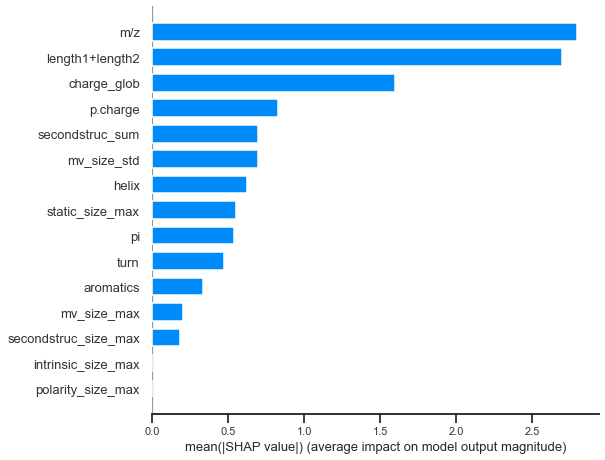

In [59]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [60]:
# shap viz
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [61]:
shap.force_plot(explainer.expected_value, shap_values, X)

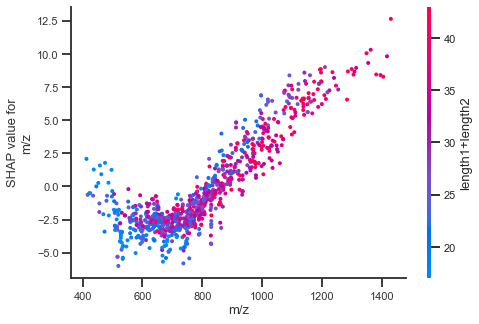

In [65]:
shap.dependence_plot("m/z", shap_values, X)

## Final Figure


In [67]:
res_melt

,rank_test_score,variable,value,Split
0,1,split0_test_score,-61.105206,Test
1,1,split0_test_score,-61.105206,Test
1152,1,split1_test_score,-65.038881,Test
1153,1,split1_test_score,-65.038881,Test
2304,1,split2_test_score,-58.725437,Test
2305,1,split2_test_score,-58.725437,Test
3456,1,split0_train_score,-9.592116,Train
3457,1,split0_train_score,-9.592116,Train
4608,1,split1_train_score,-8.574786,Train
4609,1,split1_train_score,-8.574786,Train


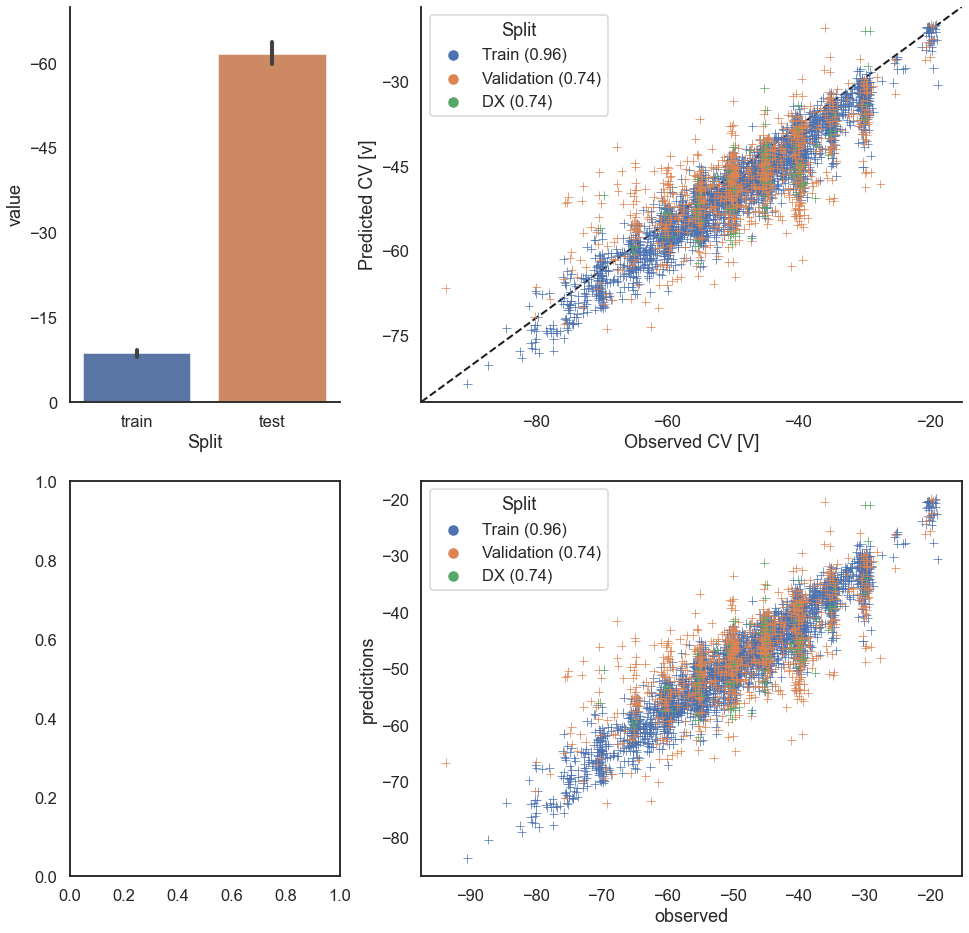

In [68]:
from matplotlib import ticker
sns.set(style="white", context="talk")
gridspec_kw={'width_ratios':[0.5, 1]}
f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16, 16), gridspec_kw=gridspec_kw)

# bar plot
ax0 = sns.barplot(x="Split", y="value", data=res_melt, ax=ax0, order=["Train", "Test"])
ax0.set_ylim(0, -70)
ax0.set(xlabel="XGBoost", ylabel="neg. mean squared error")
ax0.yaxis.set_major_locator(ticker.MaxNLocator(5))
sns.despine(ax=ax0)

ax1 = sns.scatterplot(y="predictions", x="observed", hue="Split", data=predictions_df, marker="+", s=80, ax=ax1)
x0, x1 = ax1.get_xlim()
y0, y1 = ax1.get_ylim()
ax1.plot([x0, x1], [y0, y1], ls="--", zorder=-1, lw=2, c="k")
ax1.set(xlabel="Observed CV [V]", ylabel="Predicted CV [v]")
ax1.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax1.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax1.set(xlim=(x0, x1), ylim=(y0, y1))
sns.despine(ax=ax1)


ax2 = sns.barplot(x="Split", y="value", data=res_melt, ax=ax0, order=["train", "test"])
ax3 = sns.scatterplot(y="predictions", x="observed", hue="Split", data=predictions_df, marker="+", s=80, ax=ax3)


In [ ]:
#%%
# retrieve the shap plot from above
shap.summary_plot(shap_values, X, show=False)
_ = plt.gcf()
_.ax
#ax4 = plt.gca()

shap.dependence_plot("m/z", shap_values, X, show=False)
ax3 = plt.gca()
